# Goal

The aim of this notebook is to compare the mappability of profiles obtained with the different databases on CAMI challenge data

# Init

In [1]:
library(tidyverse)
library(stringr)
library(forcats)
library(cowplot)
library(data.table)
library(glue)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
“package ‘ggplot2’ was built under R version 3.4.3”Warning message:
“package ‘tibble’ was built under R version 3.4.3”Warning message:
“package ‘tidyr’ was built under R version 3.4.3”Warning message:
“package ‘purrr’ was built under R version 3.4.3”Warning message:
“package ‘dplyr’ was built under R version 3.4.3”Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘stringr’ was built under R version 3.4.3”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“package ‘data.table’ was built under R version 3.4.3”
Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked fr

# Var

In [2]:
work_dir = "/ebio/abt3_projects/Struo/struo_benchmark/data/profiles_cami"

## Dataframe with Kraken classification reads

In [3]:
# Kraken proportion of reads mapped
database = c("GTDB", "progenomes", "defaults")
kraken_logs = map(database, 
                  function(x) file.path(work_dir, x, "logs/kraken") %>% 
                  list.files(., full.names = T)) %>% unlist

In [4]:
read_klog = function(path){
    
    # Sample community name
    community_name = path %>%
        basename %>%
        str_replace(., ".log", "")

    # Database
    db = path %>%
        str_split("/", simplify = T) %>%
        nth(8)
    # Read file line by line
    # Keep lines with classified and unclassified reads
    # create table with data for each sample
    readLines(path) %>%
        data.frame(txt = .) %>%
        tail(., n=2) %>%
        separate(txt, into = c("seqs", "category"), sep = "sequences") %>%
        mutate(seqs = as.numeric(seqs), 
               category = c("classified", "unclassified"), 
               community = rep(community_name, 2), 
               database = rep(db, 2))
}



In [5]:
kraken_classified_complete = map_df(kraken_logs, function(x) read_klog(x)) %>% 
                           arrange(community)
                           
kraken_classified_complete %>% head

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.3”

seqs,category,community,database
50298874,classified,H_S001,GTDB
4518655,unclassified,H_S001,GTDB
48738068,classified,H_S001,progenomes
6079461,unclassified,H_S001,progenomes
43156176,classified,H_S001,defaults
11661353,unclassified,H_S001,defaults


In [6]:
kraken_classified = kraken_classified_complete %>% 
    group_by(database, community) %>%
    mutate(sum = sum(seqs)) %>% 
    ungroup %>%
    mutate(proportion = round((seqs/sum)* 100, 2)) %>%
    select(-sum) %>%
    filter(category == "classified") %>%
    arrange(community, -proportion) %>%
    mutate(database = fct_recode(database, RefSeq = "defaults", proGenomes = "progenomes")) %>%
    mutate(database = fct_relevel(database, c("RefSeq", "proGenomes", "GTDB")))
kraken_classified %>% head

seqs,category,community,database,proportion
50298874,classified,H_S001,GTDB,91.76
48738068,classified,H_S001,proGenomes,88.91
43156176,classified,H_S001,RefSeq,78.73
50459497,classified,H_S002,GTDB,92.05
48748854,classified,H_S002,proGenomes,88.93
43009456,classified,H_S002,RefSeq,78.46


## Read Bracken logs

In [7]:
# Kraken proportion of reads mapped
database = c("GTDB", "progenomes", "defaults")
bracken_logs = map(database, 
                  function(x) file.path(work_dir, x, "logs/bracken") %>% 
                  list.files(., full.names = T)) %>% unlist

In [8]:
read_blog = function(path){
    
    # Synth community name
    community_name = path %>%
        basename %>%
        str_replace(., ".log", "")

    # Database
    db = path %>%
        str_split("/", simplify = T) %>%
        nth(8)
    
    
    # Read file line by line
    # Keep lines with total and used reads at the species level
    # create table with data for each sample
    readLines(path) %>%
        data.frame(txt = .) %>%
        filter(str_detect(txt," Total reads in sample") | str_detect(txt,"Total reads kept")) %>%
        separate(txt, into = c("txt", "seqs"), sep = ":") %>%
        select("seqs") %>% 
        mutate(seqs = as.numeric(seqs), 
               category = c("Total", "Used"), 
               community = rep(community_name, 2), 
               database = rep(db, 2))
}

In [9]:
bracken_used_complete = map_df(bracken_logs, function(x) read_blog(x)) %>% 
    arrange(community) %>%
    mutate(database = fct_recode(database, RefSeq = "defaults", proGenomes = "progenomes")) %>%
    mutate(database = fct_relevel(database, c("RefSeq", "proGenomes", "GTDB")))
                           
bracken_used_complete %>% head

seqs,category,community,database
54817529,Total,H_S001,GTDB
45994859,Used,H_S001,GTDB
54817529,Total,H_S001,proGenomes
46466500,Used,H_S001,proGenomes
54817529,Total,H_S001,RefSeq
32420496,Used,H_S001,RefSeq


## Bracken species table

In [10]:
bracken_tables = function(file_path){
    tax_levels = c("Domain", "Phylum", "Class",
                   "Orden", "Family", "Genus", "Species")
    
    id_ranks = c("id_cellular", "id_Domain", "id_Phylum", "id_Class",
               "id_Order", "id_Family", "id_Genus",
               "id_Species")  
    
    # Read table, select columns and separate taxonomy
    tbl_raw = read_delim(file_path, delim = "\t") %>%
        select(-c(name, taxonomy_lvl)) %>%
        separate(taxonomy, into = tax_levels, sep = ";") %>%
        separate(taxIDs, into = id_ranks, sep = ";") %>%
        select(-id_cellular)
        
    
    # Create fractiion and count tables
    # Raw counts
    tbl_count = tbl_raw %>% 
        select(-ends_with("_frac"))
    
    # Relative abudnances
    tbl_fraction = tbl_raw %>% 
        select(-ends_with("_num")) 
    
    percentages = tbl_fraction %>% 
        select(ends_with("_frac")) %>%
        (function(x) (x * 100))
         
    tbl_fraction = tbl_fraction %>% 
        select(-ends_with("_frac")) %>%
        bind_cols(percentages)
        
    
    list(relabund = tbl_fraction, count = tbl_count)
}

In [11]:
# Paths
defaults_bracken_path = file.path(work_dir, "defaults/kraken/all-combined-bracken.tsv")
progenomes_bracken_path = file.path(work_dir, "progenomes/kraken/all-combined-bracken.tsv")
gtdb_bracken_path = file.path(work_dir, "GTDB/kraken/all-combined-bracken.tsv")


In [12]:
# Defaults
bracken_cami_defaults = bracken_tables(defaults_bracken_path)
defaults_relabund = bracken_cami_defaults$relabund

# progenomes
bracken_cami_progenomes = bracken_tables(progenomes_bracken_path)
progenomes_relabund = bracken_cami_progenomes$relabund

# GTDB
bracken_cami_gtdb = bracken_tables(gtdb_bracken_path)
gtdb_relabund = bracken_cami_gtdb$relabund

Parsed with column specification:
cols(
  name = col_character(),
  taxonomy_id = col_integer(),
  taxonomy_lvl = col_character(),
  taxonomy = col_character(),
  taxIDs = col_character(),
  H_S001_num = col_integer(),
  H_S001_frac = col_double(),
  H_S002_num = col_integer(),
  H_S002_frac = col_double(),
  H_S003_num = col_integer(),
  H_S003_frac = col_double(),
  H_S004_num = col_integer(),
  H_S004_frac = col_double(),
  H_S005_num = col_integer(),
  H_S005_frac = col_double()
)
Warning message:
“Too many values at 2051 locations: 3, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, ...”Warning message:
“Too few values at 34 locations: 296, 345, 383, 491, 648, 696, 856, 886, 1000, 1016, 1099, 1287, 1384, 1510, 1534, 1640, 1754, 2019, 2024, 2107, ...”Parsed with column specification:
cols(
  name = col_character(),
  taxonomy_id = col_integer(),
  taxonomy_lvl = col_character(),
  taxonomy = col_character(),
  taxIDs = col_character(),
  H_S001_num = col_inte

## Read HUMANn2 Files

In [13]:
hmn_names = c('Gene_Family',
              'H_S001',
              'H_S002',
              'H_S003',
              'H_S004',
              'H_S005')

### Read HUMANn2 Logs

In [14]:
read_hlog = function(path){
    
    # Synth community name
    community_name = path %>%
        basename %>%
        str_replace(., ".log", "")

    # Database
    db = path %>%
        str_split("/", simplify = T) %>%
        nth(8)
    
    
    # Read file line by line
    # Keep lines with total and used reads at the species level
    # create table with data for each sample
    grep_cmd = glue('grep "Unaligned reads after" {path}', path = path)
    system(grep_cmd, intern = T) %>% 
        data.frame(txt = .) %>%
        separate(txt, into = c("Stamp", "txt", "unmapped"), sep = ": ") %>%
        select("unmapped") %>%
        mutate(unmapped = str_replace(unmapped, " %", "")) %>%
        mutate(unmapped = as.numeric(unmapped), 
               category = c("Nucleotide", "Translated"), 
               community = rep(community_name, 2), 
               database = rep(db, 2))
}

In [15]:
# Humann2 proportion of reads unmapped
database = c("GTDB", "progenomes", "defaults")
humann_logs = map(database, 
                  function(x) file.path(work_dir, x, "logs/humann2") %>% 
                  list.files(., full.names = T)) %>% unlist

In [16]:
human_unmapped = map_df(humann_logs, function(x) read_hlog(x)) %>% 
    arrange(community) %>%
    mutate(database = fct_recode(database, ChocoPhlAn = "defaults", proGenomes = "progenomes")) %>%
    mutate(database = fct_relevel(database, c("ChocoPhlAn", "proGenomes", "GTDB")))
                      
human_mapped = human_unmapped %>%
    mutate(proportion = 100 - unmapped) %>%
    select(-unmapped) 
                        
human_mapped %>% head

category,community,database,proportion
Nucleotide,H_S001,GTDB,69.03127
Translated,H_S001,GTDB,76.62983
Nucleotide,H_S001,proGenomes,70.18767
Translated,H_S001,proGenomes,76.16209
Nucleotide,H_S001,ChocoPhlAn,71.39921
Translated,H_S001,ChocoPhlAn,77.15804


# Assessment of results

In [17]:
# Colors
dbs_pallete = c("#969696", "#1879bf", "#1db628")

## Tax Profile

### Kraken - proportion of mapped reads

In [18]:
# Summary of mapped reads per database
kraken_classified %>%
    group_by(database) %>% 
    summarise(mean = mean(proportion), sd = sd(proportion))

database,mean,sd
RefSeq,78.490,0.1544345
proGenomes,89.124,0.2158240
GTDB,92.086,0.2104281


In [19]:
kraken_classified %>% head

seqs,category,community,database,proportion
50298874,classified,H_S001,GTDB,91.76
48738068,classified,H_S001,proGenomes,88.91
43156176,classified,H_S001,RefSeq,78.73
50459497,classified,H_S002,GTDB,92.05
48748854,classified,H_S002,proGenomes,88.93
43009456,classified,H_S002,RefSeq,78.46


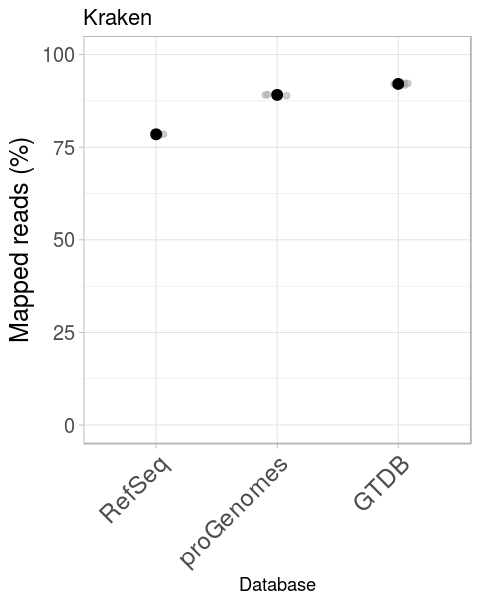

In [20]:
options(repr.plot.width = 4, repr.plot.height = 5)
k_plt = kraken_classified %>%
    ggplot(aes(x = database, y = (proportion))) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "Kraken") +
        lims(y = c(0,100))


plot(k_plt)

### Bracken - proportion of used read at species level

In [21]:
# Determine the number of reads actually used by Bracken
br_total = bracken_used_complete %>% 
    filter(category == "Total") %>%
    pull(seqs)

br_used = bracken_used_complete %>% 
    filter(category == "Used") %>%
    pull(seqs)

br_proportion = bracken_used_complete %>% 
    filter(category == "Used") %>%
    select(community, database) %>%
    mutate(proportion = (br_used /br_total)*100)

br_proportion %>% head

community,database,proportion
H_S001,GTDB,83.90539
H_S001,proGenomes,84.76577
H_S001,RefSeq,59.14257
H_S002,GTDB,84.09309
H_S002,proGenomes,84.75719
H_S002,RefSeq,59.00685


In [22]:
# Summary of used reads per database
br_proportion %>%
    group_by(database) %>% 
    summarise(mean = mean(proportion), sd = sd(proportion))

database,mean,sd
RefSeq,59.27913,0.2479790
proGenomes,84.86596,0.1041589
GTDB,83.96041,0.1378634


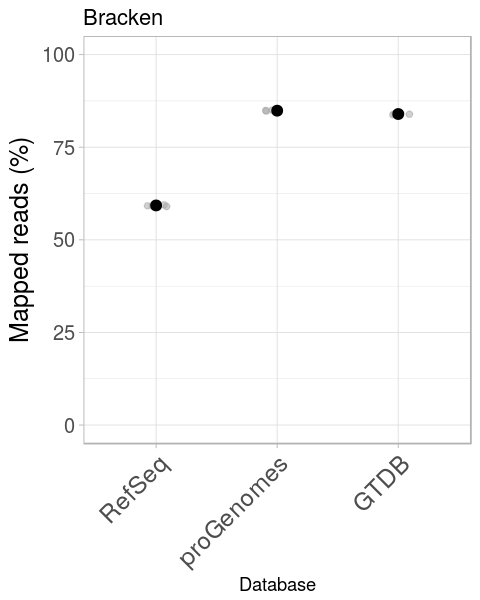

In [23]:
options(repr.plot.width = 4, repr.plot.height = 5)
b_plt = br_proportion %>%
    ggplot(aes(x = database, y = proportion)) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "Bracken") +
        lims(y = c(0,100))


plot(b_plt)

### Kraken-Bracken Plots

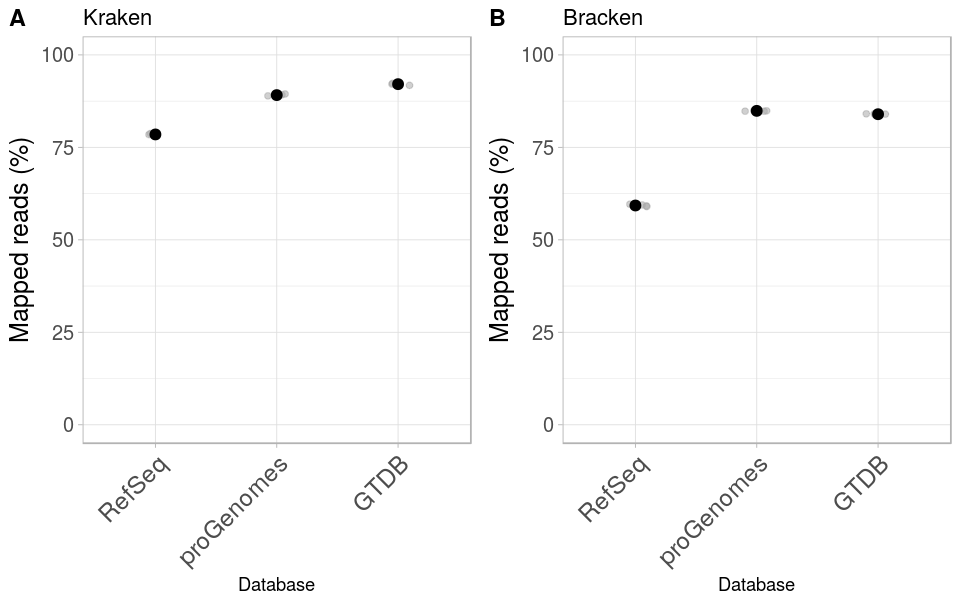

In [24]:
# Kraken and Bracken mapping
options(repr.plot.width = 8, repr.plot.height = 5)
plot_grid(k_plt, b_plt, nrow = 1, labels = "AUTO")

## Functional Profile

### HUMANn2 proportion of mapped reads after nucleotide search

In [25]:
hmn2_proportion = human_mapped %>%
    filter(category == "Nucleotide") %>%
    select(-category)

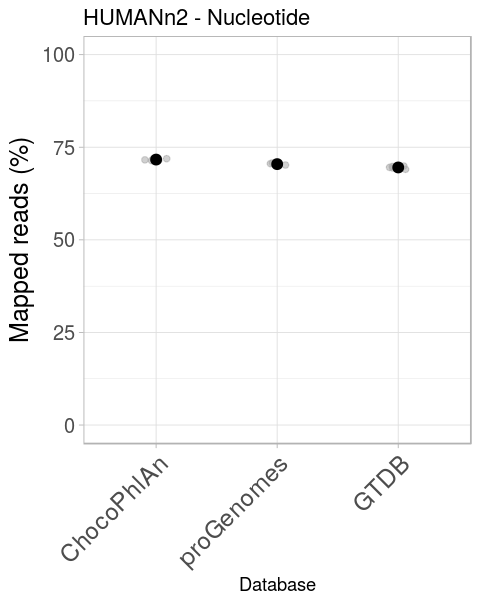

In [26]:
options(repr.plot.width = 4, repr.plot.height = 5)
hmn2_nuc_plt = hmn2_proportion %>%
    ggplot(aes(x = database, y = proportion)) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "HUMANn2 - Nucleotide") +
        lims(y = c(0,100))


plot(hmn2_nuc_plt)

### HUMANn2 proportion of mapped reads after translated search

In [27]:
hmn2_proportion = human_mapped %>%
    filter(category == "Translated") %>%
    select(-category)

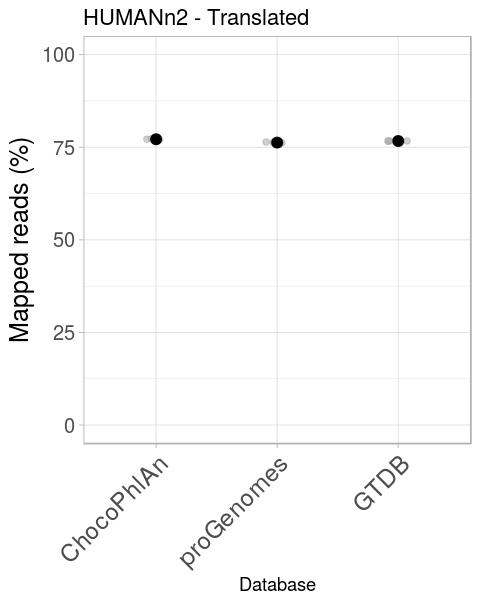

In [28]:
options(repr.plot.width = 4, repr.plot.height = 5)
hmn2_trns_plt = hmn2_proportion %>%
    ggplot(aes(x = database, y = proportion)) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "HUMANn2 - Translated") +
        lims(y = c(0,100))


plot(hmn2_trns_plt)

# All plots combined 

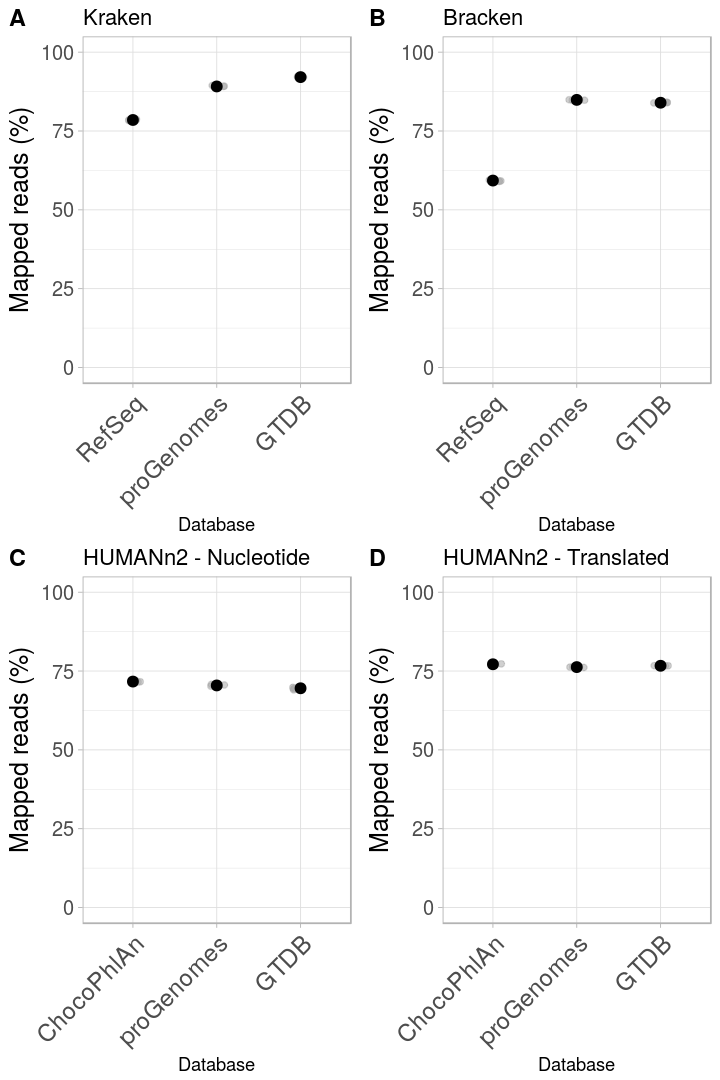

In [29]:
# Kraken and Bracken mapping
options(repr.plot.width = 6, repr.plot.height = 9)
final_plot = plot_grid(k_plt, b_plt, hmn2_nuc_plt, hmn2_trns_plt, nrow = 2, labels = "AUTO")
final_plot

In [55]:
# Save plot
plot_file = "./images/CAMI_plot_combined.png"
save_plot(filename = plot_file, plot = final_plot,
          base_height = 9, base_width = 6, dpi = 300)

# Session Info

In [30]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/UpSetR/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/UpSetR/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2        glue_1.2.0          data.table_1.10.4-3
 [4] cowplot_0.9.3       forcats_0.2.0       stringr_1.2.0      
 [7] dplyr_0.7.4         purrr_0.2.4         readr_1.1.1        
[10] tidyr_0.7.2         tibble_1.4.1        ggplot2_2.2.1      
[13] tidyverse_1.1.1    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.14        lubridate_1.7.4     lattice_0.20-35    
 [4] assertthat_0.2.0    digest_0.6.13       IRdisplay_0.4.4    
 [7] R6_2.2.2            cellranger_1.1.0    plyr_1.8.4         
[10] repr_0.15.0      